Inisialisasi
=====

In [1]:
import matplotlib.pyplot
import pandas as pd
import re
import scipy.cluster.hierarchy
import sklearn.cluster
import sklearn.preprocessing

Preprocessing
=====

In [2]:
# Muat data
ceramic = pd.read_csv('Chemical_Composion_of_Ceramic.csv')
ceramic

,Ceramic Name,Part,Na2O,MgO,Al2O3,SiO2,K2O,CaO,TiO2,Fe2O3,MnO,CuO,ZnO,PbO2,Rb2O,SrO,Y2O3,ZrO2,P2O5
0,FLQ-1-b,Body,0.62,0.38,19.61,71.99,4.84,0.31,0.07,1.18,630,10,70,10,430,0,40,80,90
1,FLQ-2-b,Body,0.57,0.47,21.19,70.09,4.98,0.49,0.09,1.12,380,20,80,40,430,-10,40,100,110
2,FLQ-3-b,Body,0.49,0.19,18.60,74.70,3.47,0.43,0.06,1.07,420,20,50,50,380,40,40,80,200
3,FLQ-4-b,Body,0.89,0.30,18.01,74.19,4.01,0.27,0.09,1.23,460,20,70,60,380,10,40,70,210
4,FLQ-5-b,Body,0.03,0.36,18.41,73.99,4.33,0.65,0.05,1.19,380,40,90,40,360,10,30,80,150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,DY-M-3-g,Glaze,0.34,0.55,12.37,70.70,5.33,8.06,0.06,1.61,1250,10,90,30,250,520,30,140,690
84,DY-QC-1-g,Glaze,0.72,0.34,12.20,72.19,6.19,6.06,0.04,1.27,1700,60,110,10,270,540,40,120,630
85,DY-QC-2-g,Glaze,0.23,0.24,12.99,71.81,5.25,7.15,0.05,1.29,750,40,100,0,240,470,40,120,480
86,DY-QC-3-g,Glaze,0.14,0.46,12.62,69.16,4.34,11.03,0.05,1.20,920,40,90,20,230,470,40,130,1100


In [3]:
# Pre-proses data:
# * Datanya sudah diklasifikasi pada nama keramiknya, jadi pisahkan namanya.
# * Konsentrasi Na2O, MgO, Al2O3, SiO2, K2O, CaO, TiO2, dan Fe2O3 yang diberikan
#   adalah dalam Berat Persen (Wt%), jadi nilai ini harus diubah ke PPM
name_pattern = re.compile(r"([\w\-]+)\-\d+\-[b|g]")
ceramic_convert = ['Na2O', 'MgO', 'Al2O3', 'SiO2', 'K2O', 'CaO', 'TiO2', 'Fe2O3']

ceramic_type = []
ceramic_new_cont = {}

for i in ceramic.iloc:
    regex_match = name_pattern.match(i['Ceramic Name'])
    ceramic_type.append(regex_match.group(1))
    for j in ceramic_convert:
        ceramic_new_cont[j] = int(i[j] * 10000)

ceramic_processed = ceramic.copy()
ceramic_processed.insert(1, 'Type', ceramic_type)
ceramic_processed.drop('Ceramic Name', axis=1, inplace=True)

for i in ceramic_convert:
    ceramic_processed[i] = (ceramic_processed[i] * 10000).astype('int')

In [4]:
# Tampilkan data yang sudah di preproses
ceramic_processed

,Type,Part,Na2O,MgO,Al2O3,SiO2,K2O,CaO,TiO2,Fe2O3,MnO,CuO,ZnO,PbO2,Rb2O,SrO,Y2O3,ZrO2,P2O5
0,FLQ,Body,6200,3800,196100,719900,48400,3100,700,11800,630,10,70,10,430,0,40,80,90
1,FLQ,Body,5699,4700,211900,700900,49800,4900,900,11200,380,20,80,40,430,-10,40,100,110
2,FLQ,Body,4900,1900,186000,747000,34700,4300,600,10700,420,20,50,50,380,40,40,80,200
3,FLQ,Body,8900,3000,180100,741900,40100,2700,900,12300,460,20,70,60,380,10,40,70,210
4,FLQ,Body,300,3600,184100,739900,43300,6500,500,11900,380,40,90,40,360,10,30,80,150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,DY-M,Glaze,3400,5500,123699,707000,53300,80600,600,16100,1250,10,90,30,250,520,30,140,690
84,DY-QC,Glaze,7200,3400,122000,721900,61900,60599,400,12700,1700,60,110,10,270,540,40,120,630
85,DY-QC,Glaze,2300,2400,129900,718100,52500,71500,500,12900,750,40,100,0,240,470,40,120,480
86,DY-QC,Glaze,1400,4600,126199,691600,43400,110300,500,12000,920,40,90,20,230,470,40,130,1100


In [5]:
# Pada bagian ini kita hanya akan melakukan clustering pada bagian "Body" saja
# Untuk melakukan clustering pada "Glaze" akan membuat notebook ini terlalu panjang.
ceramic_body = ceramic_processed[ceramic_processed['Part'] == 'Body'].copy()
ceramic_body.drop('Part', axis=1, inplace=True)
ceramic_body.head()

,Type,Na2O,MgO,Al2O3,SiO2,K2O,CaO,TiO2,Fe2O3,MnO,CuO,ZnO,PbO2,Rb2O,SrO,Y2O3,ZrO2,P2O5
0,FLQ,6200,3800,196100,719900,48400,3100,700,11800,630,10,70,10,430,0,40,80,90
1,FLQ,5699,4700,211900,700900,49800,4900,900,11200,380,20,80,40,430,-10,40,100,110
2,FLQ,4900,1900,186000,747000,34700,4300,600,10700,420,20,50,50,380,40,40,80,200
3,FLQ,8900,3000,180100,741900,40100,2700,900,12300,460,20,70,60,380,10,40,70,210
4,FLQ,300,3600,184100,739900,43300,6500,500,11900,380,40,90,40,360,10,30,80,150


In [6]:
# Hapus kolom "Type" pada dataframe baru
ceramic_body_omit = ceramic_body.drop(['Type'], axis=1)
ceramic_body_omit.head()

,Na2O,MgO,Al2O3,SiO2,K2O,CaO,TiO2,Fe2O3,MnO,CuO,ZnO,PbO2,Rb2O,SrO,Y2O3,ZrO2,P2O5
0,6200,3800,196100,719900,48400,3100,700,11800,630,10,70,10,430,0,40,80,90
1,5699,4700,211900,700900,49800,4900,900,11200,380,20,80,40,430,-10,40,100,110
2,4900,1900,186000,747000,34700,4300,600,10700,420,20,50,50,380,40,40,80,200
3,8900,3000,180100,741900,40100,2700,900,12300,460,20,70,60,380,10,40,70,210
4,300,3600,184100,739900,43300,6500,500,11900,380,40,90,40,360,10,30,80,150


In [7]:
# Buat scaler bagian "Body" untuk K-Means
ceramic_cols = ['Na2O', 'MgO', 'Al2O3', 'SiO2', 'K2O', 'CaO', 'TiO2', 'Fe2O3', 'MnO', 'CuO', 'ZnO', 'PbO2', 'Rb2O', 'SrO', 'Y2O3', 'ZrO2', 'P2O5']
ceramic_body_scaler = sklearn.preprocessing.StandardScaler()
ceramic_body_scaled = ceramic_body_scaler.fit_transform(ceramic_body_omit[ceramic_cols])
ceramic_body_scaled_labeled = pd.DataFrame(ceramic_body_scaled, columns=ceramic_cols)

In [8]:
ceramic_body_omit.describe()

,Na2O,MgO,Al2O3,SiO2,K2O,CaO,TiO2,Fe2O3,MnO,CuO,ZnO,PbO2,Rb2O,SrO,Y2O3,ZrO2,P2O5
count,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000
mean,3974.977273,3422.727273,218120.386364,692218.113636,49488.590909,2772.727273,1222.727273,18779.522727,388.636364,28.181818,93.636364,47.272727,355.227273,15.454545,50.454545,171.818182,112.272727
std,2114.947088,1250.462916,23007.121808,30883.563765,8463.576509,2212.371519,627.235958,5838.278957,100.593377,18.958060,20.696130,26.620820,47.027386,14.379337,12.566945,69.626002,67.509298
min,300.000000,1800.000000,176500.000000,638800.000000,27300.000000,1200.000000,400.000000,9600.000000,180.000000,0.000000,40.000000,0.000000,230.000000,-10.000000,30.000000,70.000000,50.000000
25%,2575.000000,2375.000000,195900.000000,666250.000000,44900.000000,1500.000000,700.000000,12700.000000,327.500000,20.000000,80.000000,27.500000,320.000000,10.000000,40.000000,127.500000,70.000000
50%,3700.000000,3250.000000,218349.500000,689900.000000,50050.000000,1800.000000,1050.000000,18600.000000,380.000000,25.000000,90.000000,45.000000,370.000000,10.000000,50.000000,170.000000,95.000000
75%,5525.000000,4525.000000,233099.750000,715874.250000,55000.000000,2850.000000,1525.000000,21550.000000,422.500000,40.000000,110.000000,70.000000,382.500000,20.000000,60.000000,200.000000,140.000000
max,8900.000000,7000.000000,264800.000000,749900.000000,65600.000000,12600.000000,2900.000000,31100.000000,650.000000,80.000000,120.000000,100.000000,450.000000,70.000000,80.000000,390.000000,440.000000


In [9]:
ceramic_body_scaled_labeled.describe()

,Na2O,MgO,Al2O3,SiO2,K2O,CaO,TiO2,Fe2O3,MnO,CuO,ZnO,PbO2,Rb2O,SrO,Y2O3,ZrO2,P2O5
count,4.400000e+01,4.400000e+01,4.400000e+01,4.400000e+01,4.400000e+01,4.400000e+01,4.400000e+01,4.400000e+01,4.400000e+01,4.400000e+01,4.400000e+01,4.400000e+01,4.400000e+01,4.400000e+01,4.400000e+01,4.400000e+01,4.400000e+01
mean,1.211152e-16,1.488708e-16,4.516589e-16,-3.355901e-16,-3.128810e-16,8.831320e-17,-2.428613e-17,-1.261617e-16,1.009294e-16,-1.261617e-16,-1.848269e-16,-7.569702e-18,-4.289498e-16,-1.261617e-18,6.055762e-17,4.100255e-17,1.110223e-16
std,1.011561e+00,1.011561e+00,1.011561e+00,1.011561e+00,1.011561e+00,1.011561e+00,1.011561e+00,1.011561e+00,1.011561e+00,1.011561e+00,1.011561e+00,1.011561e+00,1.011561e+00,1.011561e+00,1.011561e+00,1.011561e+00,1.011561e+00
min,-1.757710e+00,-1.312704e+00,-1.829936e+00,-1.749658e+00,-2.651966e+00,-7.190970e-01,-1.326835e+00,-1.590477e+00,-2.098035e+00,-1.503721e+00,-2.621575e+00,-1.796310e+00,-2.693644e+00,-1.790683e+00,-1.646464e+00,-1.479265e+00,-9.330962e-01
25%,-6.695971e-01,-8.475582e-01,-9.769704e-01,-8.505603e-01,-5.484254e-01,-5.819282e-01,-8.430170e-01,-1.053360e+00,-6.147837e-01,-4.365641e-01,-6.665021e-01,-7.513413e-01,-7.577401e-01,-3.837177e-01,-8.415260e-01,-6.438765e-01,-6.334156e-01
50%,-1.315193e-01,-1.397276e-01,1.007351e-02,-7.592756e-02,6.709924e-02,-4.447594e-01,-2.785621e-01,-3.110475e-02,-8.684676e-02,-1.697749e-01,-1.777339e-01,-8.636107e-02,3.177620e-01,-3.837177e-01,-3.658809e-02,-2.641545e-02,-2.588150e-01
75%,7.413626e-01,8.916827e-01,6.586022e-01,7.748337e-01,6.587200e-01,3.533135e-02,4.874837e-01,4.800228e-01,3.405307e-01,6.305926e-01,7.998025e-01,8.636107e-01,5.866375e-01,3.197647e-01,7.683498e-01,4.094394e-01,4.154662e-01
max,2.355596e+00,2.893832e+00,2.052377e+00,1.889314e+00,1.925625e+00,4.493317e+00,2.704985e+00,2.134690e+00,2.628257e+00,2.764906e+00,1.288571e+00,2.003577e+00,2.038565e+00,3.837177e+00,2.378226e+00,3.169854e+00,4.910674e+00


K-Means
=====

In [10]:
ceramic_body_scaled_labeled.head()

,Na2O,MgO,Al2O3,SiO2,K2O,CaO,TiO2,Fe2O3,MnO,CuO,ZnO,PbO2,Rb2O,SrO,Y2O3,ZrO2,P2O5
0,1.064209,0.305195,-0.968177,0.906693,-0.130108,0.149639,-0.843017,-1.209297,2.427139,-0.970143,-1.155270,-1.416321,1.608365,-1.087200,-0.841526,-1.333980,-0.333735
1,0.824585,1.033249,-0.273494,0.284367,0.037219,0.972651,-0.520471,-1.313255,-0.086847,-0.436564,-0.666502,-0.276355,1.608365,-1.790683,-0.841526,-1.043410,-0.034055
2,0.442430,-1.231809,-1.412247,1.794327,-1.767523,0.698314,-1.004290,-1.399887,0.315391,-0.436564,-2.132807,0.103633,0.532862,1.726730,-0.841526,-1.333980,1.314508
3,2.355596,-0.341965,-1.671654,1.627282,-1.122118,-0.033253,-0.520471,-1.122665,0.717629,-0.436564,-1.155270,0.483622,0.532862,-0.383718,-0.841526,-1.479265,1.464348
4,-1.757710,0.143405,-1.495785,1.561774,-0.739656,1.704218,-1.165563,-1.191971,-0.086847,0.630593,-0.177734,-0.276355,0.102662,-0.383718,-1.646464,-1.333980,0.565306


Text(0, 0.5, 'Inertia')

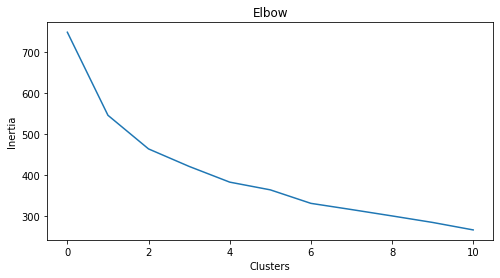

In [11]:
#Tampilkan grafik Elbow untuk mencari jumlah K
ceramic_body_clusters = []
for i in range(1, 12):
    testkmeans = sklearn.cluster.KMeans(i).fit(ceramic_body_scaled_labeled)
    ceramic_body_clusters.append(testkmeans.inertia_)

# tampilkan plot
fig, ax = matplotlib.pyplot.subplots(figsize=(8,4))
ax.plot(ceramic_body_clusters)
ax.set_title('Elbow')
ax.set_xlabel('Clusters')
ax.set_ylabel('Inertia')

In [12]:
# Terlihat diatas bahwa K=4..7 keliatannya bagus
def kmeans_and_train(n, data):
    kmeans = sklearn.cluster.KMeans(n)
    kmeans.fit(data)
    return kmeans

ceramic_body_kmeans = [kmeans_and_train(k, ceramic_body_scaled_labeled) for k in range(4, 8)]

In [13]:
# Tambah label
ceramic_body_scaled_labeled_kmeans = ceramic_body_scaled_labeled.copy()

for i in range(len(ceramic_body_kmeans)):
    ceramic_body_scaled_labeled_kmeans[f"KM_{i + 4}"] = ceramic_body_kmeans[i].labels_

ceramic_body_scaled_labeled_kmeans.head()

,Na2O,MgO,Al2O3,SiO2,K2O,CaO,TiO2,Fe2O3,MnO,CuO,...,PbO2,Rb2O,SrO,Y2O3,ZrO2,P2O5,KM_4,KM_5,KM_6,KM_7
0,1.064209,0.305195,-0.968177,0.906693,-0.130108,0.149639,-0.843017,-1.209297,2.427139,-0.970143,...,-1.416321,1.608365,-1.087200,-0.841526,-1.333980,-0.333735,2,4,1,3
1,0.824585,1.033249,-0.273494,0.284367,0.037219,0.972651,-0.520471,-1.313255,-0.086847,-0.436564,...,-0.276355,1.608365,-1.790683,-0.841526,-1.043410,-0.034055,2,4,1,3
2,0.442430,-1.231809,-1.412247,1.794327,-1.767523,0.698314,-1.004290,-1.399887,0.315391,-0.436564,...,0.103633,0.532862,1.726730,-0.841526,-1.333980,1.314508,2,4,1,5
3,2.355596,-0.341965,-1.671654,1.627282,-1.122118,-0.033253,-0.520471,-1.122665,0.717629,-0.436564,...,0.483622,0.532862,-0.383718,-0.841526,-1.479265,1.464348,2,4,1,5
4,-1.757710,0.143405,-1.495785,1.561774,-0.739656,1.704218,-1.165563,-1.191971,-0.086847,0.630593,...,-0.276355,0.102662,-0.383718,-1.646464,-1.333980,0.565306,2,2,1,5


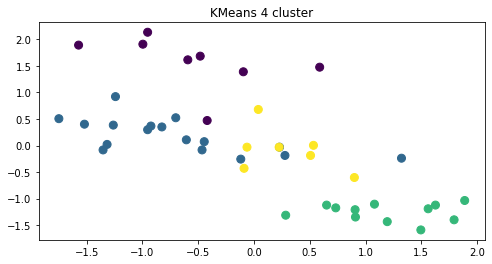

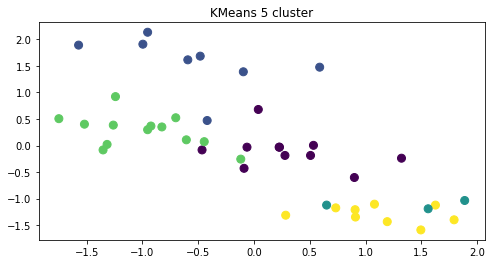

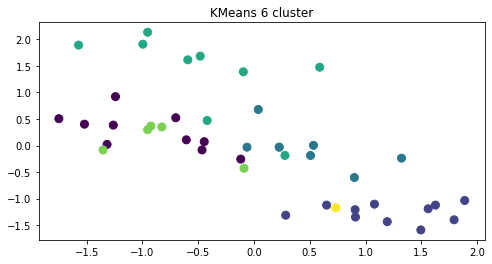

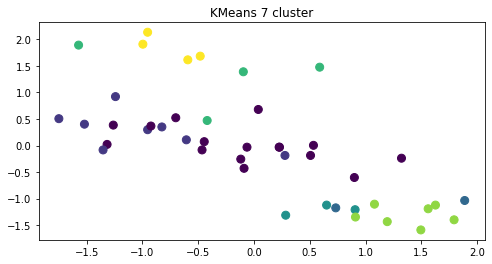

In [14]:
# Tampilkan Scatterplot
for i in range(4, 8):
    matplotlib.pyplot.figure(figsize=(8, 4))
    # SiO2 and Fe2O3
    matplotlib.pyplot.scatter(
        ceramic_body_scaled_labeled_kmeans['SiO2'],
        ceramic_body_scaled_labeled_kmeans['Fe2O3'],
        64,
        ceramic_body_scaled_labeled_kmeans[f"KM_{i}"]
    )
    matplotlib.pyplot.title(f"KMeans {i} cluster")

Hierarki
=====

In [15]:
ceramic_body_scaled_labeled.head()

,Na2O,MgO,Al2O3,SiO2,K2O,CaO,TiO2,Fe2O3,MnO,CuO,ZnO,PbO2,Rb2O,SrO,Y2O3,ZrO2,P2O5
0,1.064209,0.305195,-0.968177,0.906693,-0.130108,0.149639,-0.843017,-1.209297,2.427139,-0.970143,-1.155270,-1.416321,1.608365,-1.087200,-0.841526,-1.333980,-0.333735
1,0.824585,1.033249,-0.273494,0.284367,0.037219,0.972651,-0.520471,-1.313255,-0.086847,-0.436564,-0.666502,-0.276355,1.608365,-1.790683,-0.841526,-1.043410,-0.034055
2,0.442430,-1.231809,-1.412247,1.794327,-1.767523,0.698314,-1.004290,-1.399887,0.315391,-0.436564,-2.132807,0.103633,0.532862,1.726730,-0.841526,-1.333980,1.314508
3,2.355596,-0.341965,-1.671654,1.627282,-1.122118,-0.033253,-0.520471,-1.122665,0.717629,-0.436564,-1.155270,0.483622,0.532862,-0.383718,-0.841526,-1.479265,1.464348
4,-1.757710,0.143405,-1.495785,1.561774,-0.739656,1.704218,-1.165563,-1.191971,-0.086847,0.630593,-0.177734,-0.276355,0.102662,-0.383718,-1.646464,-1.333980,0.565306


Single Linkage
-----

Text(0.5, 1.0, 'Single Linkage')

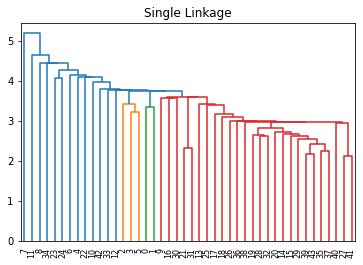

In [16]:
# Single Linkage
ceramic_body_single_link = scipy.cluster.hierarchy.linkage(ceramic_body_scaled_labeled)
scipy.cluster.hierarchy.dendrogram(ceramic_body_single_link)
matplotlib.pyplot.title("Single Linkage")

Text(0.5, 1.0, 'Single-Link Hierarcial Cluster')

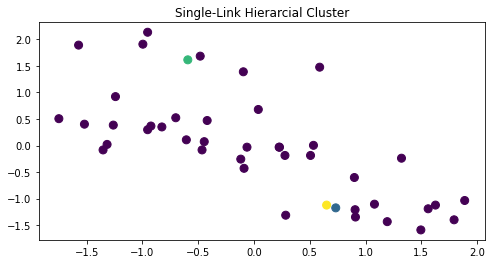

In [17]:
# 4 clusters
ceramic_body_sl_ch = scipy.cluster.hierarchy.cut_tree(ceramic_body_single_link, 4).reshape(-1, )

matplotlib.pyplot.figure(figsize=(8, 4))
# SiO2 and Fe2O3
matplotlib.pyplot.scatter(
    ceramic_body_scaled_labeled['SiO2'],
    ceramic_body_scaled_labeled['Fe2O3'],
    64,
    ceramic_body_sl_ch
)
matplotlib.pyplot.title(f"Single-Link Hierarcial Cluster")

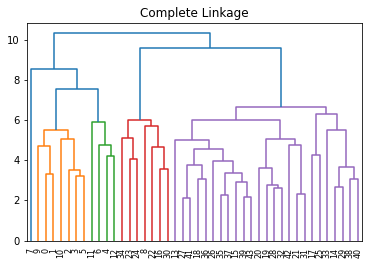

In [18]:
# Complete Linkage
ceramic_body_complete_link = scipy.cluster.hierarchy.linkage(ceramic_body_scaled_labeled, 'complete')
scipy.cluster.hierarchy.dendrogram(ceramic_body_complete_link)
matplotlib.pyplot.title("Complete Linkage")
matplotlib.pyplot.show()

Text(0.5, 1.0, 'Complete-Link Hierarcial Cluster')

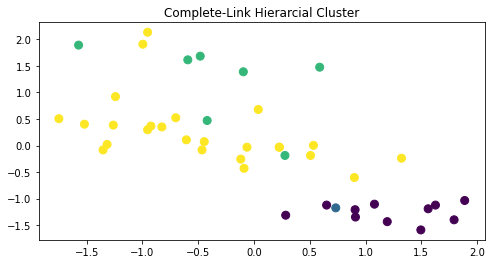

In [19]:
# 4 clusters
ceramic_body_cl_ch = scipy.cluster.hierarchy.cut_tree(ceramic_body_complete_link, 4).reshape(-1, )

matplotlib.pyplot.figure(figsize=(8, 4))
# SiO2 and Fe2O3
matplotlib.pyplot.scatter(
    ceramic_body_scaled_labeled['SiO2'],
    ceramic_body_scaled_labeled['Fe2O3'],
    64,
    ceramic_body_cl_ch
)
matplotlib.pyplot.title(f"Complete-Link Hierarcial Cluster")

DBSCAN
=====

In [20]:
ceramic_body_scaled_labeled.head()

,Na2O,MgO,Al2O3,SiO2,K2O,CaO,TiO2,Fe2O3,MnO,CuO,ZnO,PbO2,Rb2O,SrO,Y2O3,ZrO2,P2O5
0,1.064209,0.305195,-0.968177,0.906693,-0.130108,0.149639,-0.843017,-1.209297,2.427139,-0.970143,-1.155270,-1.416321,1.608365,-1.087200,-0.841526,-1.333980,-0.333735
1,0.824585,1.033249,-0.273494,0.284367,0.037219,0.972651,-0.520471,-1.313255,-0.086847,-0.436564,-0.666502,-0.276355,1.608365,-1.790683,-0.841526,-1.043410,-0.034055
2,0.442430,-1.231809,-1.412247,1.794327,-1.767523,0.698314,-1.004290,-1.399887,0.315391,-0.436564,-2.132807,0.103633,0.532862,1.726730,-0.841526,-1.333980,1.314508
3,2.355596,-0.341965,-1.671654,1.627282,-1.122118,-0.033253,-0.520471,-1.122665,0.717629,-0.436564,-1.155270,0.483622,0.532862,-0.383718,-0.841526,-1.479265,1.464348
4,-1.757710,0.143405,-1.495785,1.561774,-0.739656,1.704218,-1.165563,-1.191971,-0.086847,0.630593,-0.177734,-0.276355,0.102662,-0.383718,-1.646464,-1.333980,0.565306


In [21]:
ceramic_body_dbscan = sklearn.cluster.DBSCAN(eps=4, min_samples=4, metric='euclidean')
ceramic_body_dbscan.fit(ceramic_body_scaled_labeled)

DBSCAN(eps=4, min_samples=4)

Text(0.5, 1.0, 'DBSCAN')

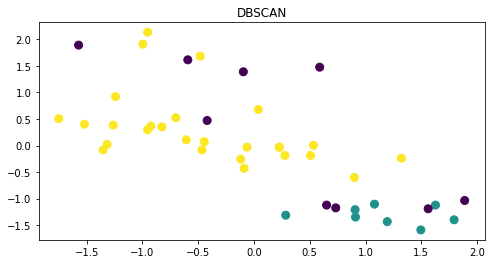

In [22]:
matplotlib.pyplot.figure(figsize=(8, 4))
# SiO2 and Fe2O3
matplotlib.pyplot.scatter(
    ceramic_body_scaled_labeled['SiO2'],
    ceramic_body_scaled_labeled['Fe2O3'],
    64,
    ceramic_body_dbscan.labels_
)
matplotlib.pyplot.title(f"DBSCAN")